In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter
style.use("seaborn-v0_8-pastel")

In [119]:
# Configurações do Pandas
pd.options.display.max_columns = 26

In [120]:
# Arrays e dicionários úteis

columns = ["NU_ANO","TP_NACIONALIDADE","TP_SEXO","TP_FAIXA_ETARIA","TP_COR_RACA","TP_ESTADO_CIVIL",
           "TP_ST_CONCLUSAO","TP_ESCOLA","IN_TREINEIRO","NO_MUNICIPIO_ESC","SG_UF_PROVA","TP_PRESENCA_CN",
           "TP_PRESENCA_CH","TP_PRESENCA_LC","TP_PRESENCA_MT","NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC",
           "NU_NOTA_MT","TP_STATUS_REDACAO","NU_NOTA_COMP1","NU_NOTA_COMP2","NU_NOTA_COMP3","NU_NOTA_COMP4",
           "NU_NOTA_COMP5","NU_NOTA_REDACAO"]

renamed_columns = ["Ano","Nacionalidade","Sexo","Idade","Cor","Estado_civil","Situacao_EM","Tipo_Escola",
                   "Treineiro","Municipio","Estado","Presenca_CN","Presenca_CH","Presenca_LC","Presenca_MT",
                   "Ciencias_Natureza","Ciencias_Humanas","Linguagens_Codigos","Matematica","Status_Redacao",
                   "Ortografia","Desenvolvimento","Informacoes","Organizacao","Proposta","Redacao"]

# Conseguindo a relação das categorias das colunas
faixa_etaria = {
    1: "Menor de 17 anos",
    2: "17 anos",
    3: "18 anos",
    4: "19 anos",
    5: "20 anos",
    6: "21 anos",
    7: "22 anos",
    8: "23 anos",
    9: "24 anos",
    10: "25 anos",
    11: "Entre 26 e 30 anos",
    12: "Entre 31 e 35 anos",
    13: "Entre 36 e 40 anos",
    14: "Entre 41 e 45 anos",
    15: "Entre 46 e 50 anos",
    16: "Entre 51 e 55 anos",
    17: "Entre 56 e 60 anos",
    18: "Entre 61 e 65 anos",
    19: "Entre 66 e 70 anos",
    20: "Maior de 70 anos"
}

estado_civil = {
    0: "Não informado",
    1: "Solteiro(a)",
    2: "Casado(a)/Mora com companheiro(a)",
    3: "Divorciado(a)/Desquitado(a)/Separado(a)",
    4: "Viúvo(a)"
}

etnia = {
    0: "Não declarado",
    1: "Branca",
    2: "Preta",
    3: "Parda",
    4: "Amarela",
    5: "Indígena",
    6: "Não dispõe da informação"
}

nacionalidade = {
    0: "Não informado",
    1: "Brasileiro(a)",
    2: "Brasileiro(a) Naturalizado(a)",
    3: "Estrangeiro(a)",
    4: "Brasileiro(a) Nato(a), nascido(a) no exterior"
}

situacao_ensino_medio = {
    1: "Já concluí o Ensino Médio",
    2: "Estou cursando e concluirei o Ensino Médio em 2022",
    3: "Estou cursando e concluirei o Ensino Médio após 2022",
    4: "Não concluí e não estou cursando o Ensino Médio"
}

tipo_instituicao = {
    1: "Não Respondeu",
    2: "Pública",
    3: "Privada"
}

treineiro = {
    1: "Sim",
    0: "Não"
}

situacao_redacao = {
    1: "Sem problemas",
    2: "Anulada",
    3: "Cópia Texto Motivador",
    4: "Em Branco",
    6: "Fuga ao tema",
    7: "Não atendimento ao tipo textual",
    8: "Texto insuficiente",
    9: "Parte desconectada"
}

In [121]:
# Pegar o arquivo .csv dos microdados de dentro de todos os zips
zip_data = {
    "Zip Files":[],
    "Folder Data":  os.listdir("information")
}

for zippedArch in zip_data["Folder Data"]:
    with zipfile.ZipFile(f"information\{zippedArch}") as zippedData:
        for file in zippedData.namelist():
            if "microdados" in file.lower() and file.endswith(".csv"):
                zip_data["Zip Files"].append(file)

In [122]:
# Lambda pra ordenar os arquivos do mais antigo para o mais novo 2015 - 2022
zip_data["Zip Files"].sort(key = lambda x: x[22:-4])
zip_data["Folder Data"].sort(key = lambda x: x[16:-4])

In [123]:
enem_collection = []

# Criando o megadataframe filtrado
for i in range(len(zip_data["Zip Files"])):
    with zipfile.ZipFile(f"information\{zip_data['Folder Data'][i]}") as microdata:
        with microdata.open(zip_data["Zip Files"][i]) as csv:
            
            data = pd.read_csv(csv,encoding="ISO-8859-1",sep=";",usecols=columns)
            # Renomeando as colunas
            data.columns = renamed_columns
            # Removendo as linhas onde não temos notas
            data.dropna(subset=["Ciencias_Natureza",'Ciencias_Humanas',"Ciencias_Humanas","Matematica","Redacao"],inplace=True)
            data.reset_index(inplace=True,drop=True)
            # Adicionando no array pra criar o Dataframe completo posteriormente
            enem_collection.append(data)


In [124]:
enem = pd.concat(enem_collection)

In [125]:
enem.groupby("Ano")[["Ciencias_Humanas","Linguaguens_Codigos","Matematica","Redacao"]].mean()

,Ciencias_Humanas,Linguaguens_Codigos,Matematica,Redacao
Ano,,,,
2015,559.268777,505.578629,468.088781,534.851685
2016,535.326088,521.042458,490.233025,530.312837
2017,521.452181,512.150346,518.831999,529.386232
2018,570.811613,528.516401,535.490047,516.057887
2019,509.889825,522.396624,523.185038,579.766602
2020,514.286982,526.019202,520.727299,581.335282
2021,523.182030,504.875292,535.197098,622.546196
2022,529.968661,519.876832,542.611168,628.950040


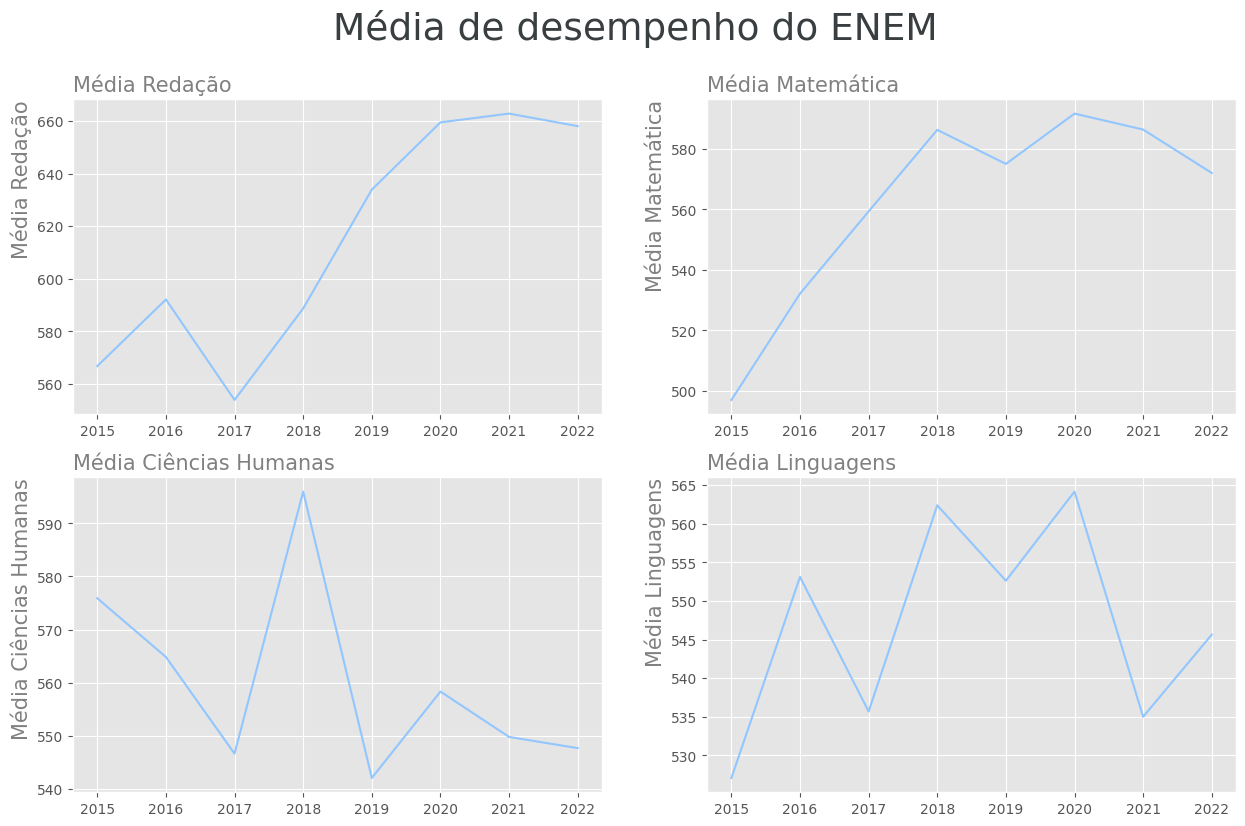

In [245]:
fig,axs = plt.subplots(2,2,figsize=(15,9))

axs[0,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Redacao"].mean())
axs[0,0].set_title("Média Redação",fontsize=15,color='gray',loc='left')
axs[0,0].set_ylabel("Média Redação",fontsize=15,color='gray',loc='top')

axs[1,0].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Ciencias_Humanas"].mean())
axs[1,0].set_title("Média Ciências Humanas",fontsize=15,color='gray',loc='left')
axs[1,0].set_ylabel("Média Ciências Humanas",fontsize=15,color='gray',loc='top')

axs[0,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Matematica"].mean())
axs[0,1].set_title("Média Matemática",fontsize=15,color='gray',loc='left')
axs[0,1].set_ylabel("Média Matemática",fontsize=15,color='gray',loc='top')

axs[1,1].plot(enem.loc[enem['Municipio']=="Vinhedo"].groupby("Ano")["Linguaguens_Codigos"].mean())
axs[1,1].set_title("Média Linguagens",fontsize=15,color='gray',loc='left')
axs[1,1].set_ylabel("Média Linguagens",fontsize=15,color='gray',loc='top')


fig.suptitle('Média de desempenho do ENEM',fontsize=27,color="#393E41")

plt.savefig('foo.png', bbox_inches='tight')

In [246]:
# Buscando os estados com maior percentual de treineiros no ano de 2022
trein_state = pd.DataFrame(enem.loc[enem['Ano']==2022].groupby("Estado")['Treineiro'].value_counts(normalize=True)).reset_index()
top_trein_states = trein_state.loc[trein_state['Treineiro']>0].sort_values("proportion",ascending=False).head(5)["Estado"]
top_trein_states = trein_state.loc[trein_state['Estado'].isin(top_trein_states)]

Text(0.0, 1.0, 'Estados com maior (%) de Treineiros')

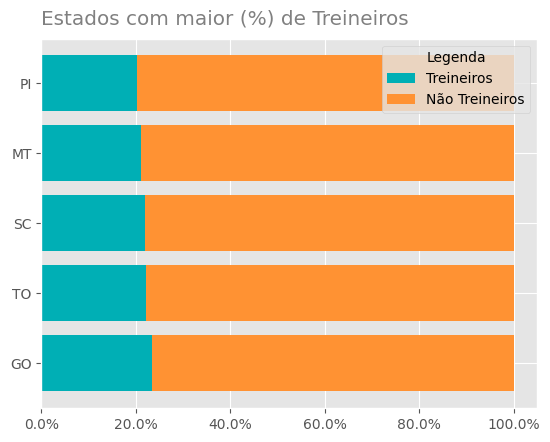

In [247]:
# Pivotando a tabela pra ficar mais fácil de usar um gráfico horizontal
top_trein_states = top_trein_states.pivot_table('proportion', ['Estado'], 'Treineiro').reset_index()
top_trein_states.columns = ['Estado',"Não Treineiros","Treineiros"]
top_trein_states = top_trein_states[['Estado',"Treineiros","Não Treineiros"]].sort_values("Treineiros",ascending=False)

# Multiplicando pra transformar em porcentagem
top_trein_states = top_trein_states.map(lambda x: x*100 if type(x) == float else x)

# Criando o gráfico
b1 = plt.barh(top_trein_states['Estado'],top_trein_states["Treineiros"],color='#00AFB5')
b2 = plt.barh(top_trein_states['Estado'],top_trein_states["Não Treineiros"],color='#FF9233',left=top_trein_states["Treineiros"])
plt.legend([b1, b2], ["Treineiros", "Não Treineiros"], title="Legenda", loc="upper right")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.title("Estados com maior (%) de Treineiros",loc='left',color='gray',pad=10)
